# FACE DETECTION MODEL: 2
Loading of face detection model

In [55]:
import numpy as np
from ultralytics import YOLO
import os
from pathlib import Path
import cv2

os.chdir("/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project")
model = YOLO("2.weights/best.pt")

classes_fd = model.names
print(f"Face detection model is able to detect following classes:\n{classes_fd}")

Face detection model is able to detect following classes:
{0: 'BABY', 1: 'EYE', 2: 'HEAD', 3: 'MOUTH', 4: 'NOSE'}


# DATASET ON BACK/ON STOMACH: 2
Extract dictionary {img_name : label} from annotations.json file

In [56]:
import json
os.chdir("/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project")

file_imgid = {}
imgid_label = {}
file_label = {}

classes_mlp = {}

with open("onback_onstomach_v2/_annotations.coco.json", "r") as f:
    dataset = json.load(f)
    
    for img in dataset["images"]:
        file_imgid[img["file_name"]] =img["id"]
    
    for label in dataset["annotations"]:
        imgid_label[label["image_id"]] = label["category_id"]
    
    for cls in dataset["categories"]:
        classes_mlp[cls["name"]]=cls["id"]
    del classes_mlp["baby"]

for file, img_id in file_imgid.items():
    if img_id in imgid_label.keys():
        file_label[file] = imgid_label[img_id]      

# EMBEDDING: element position

In [57]:
from ultralytics.engine.results import Boxes  

def embedding_builder_positions(prediction: Boxes):
    embedding_position= {
        "BABY" : 0,
        "HEAD": 1,
        "EYE": (3, 5),
        "MOUTH": 7,
        "NOSE": 9
    }
    
    vec = np.full(11, -1.0, dtype=float)
    for bbox, cls in zip(prediction.xywhn, prediction.cls):
        class_label = classes_fd[cls.item()]
        if class_label == "BABY":
            pos = embedding_position[class_label]
            
            vec[pos] = 1
        elif class_label == "EYE":
            pos = embedding_position[class_label][0] if vec[embedding_position[class_label][0]] == -1 else embedding_position[class_label][1]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]
        else:
            pos = embedding_position[class_label]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]    
    
    return vec

# Save new dataset (embedding - label) in .csv format

In [69]:
import csv

def save_embedding_label_dataset(dataset: str, embedding_type: str, X, y):    
    with open(dataset+"/"+embedding_type+".csv", "w", newline='') as f:
        writer = csv.writer(f)
        for xi, yi in zip(X, y):
            writer.writerow(list(xi) + [yi])

# Load dataset from .csv file

In [70]:
def load_embedding_label_dataset(dataset: str, embedding_type: str):
    data = np.loadtxt(dataset+"/"+embedding_type+".csv", delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]
    
    return X,y

# EMBEDDING: 1 if feature is present, -1 otherwise

In [60]:
from ultralytics.engine.results import Boxes  

def embedding_builder_flag(prediction: Boxes):    
    embedding_position= {
        "BABY" : 0,
        "HEAD": 1,
        "EYE": (2,3),
        "MOUTH": 4,
        "NOSE": 5
    }
    
    vec = np.full(6, -1.0, dtype=float)
    for cls in (prediction.cls):
        class_label = classes_fd[cls.item()]
        if class_label == "EYE":
            pos = embedding_position[class_label][0] if vec[embedding_position[class_label][0]] == -1 else embedding_position[class_label][1]
            vec[pos] = 1
        else:
            pos = embedding_position[class_label]
            vec[pos] = 1 
    return vec

# COMBINATION 1 (dataset 2, model 2, embedding with positions)

**Feature extraction with face detection and embedding creation**

In [61]:
dataset_folder = "onback_onstomach_v2"
embedding_type = "positions"

In [62]:
onback_onstomach_dataset = Path(dataset_folder)
X = []
y = []

for img in onback_onstomach_dataset.glob("*.jpg"):
    if img.name in file_label.keys():
        #DEBUG
        if len(y)%100 == 0:
            print(f"{int(len(y)*100/len(file_label))}%-->    {len(y)} / {len(file_label)} embeddings created")
        #DEBUG    
        result = model(img, conf=0.3, verbose=False)[0]
        prediction = result.boxes
        
        vec = embedding_builder_positions(prediction)
        X.append(vec)
        y.append(file_label[img.name])
        
print(f"FINISHED EMBEDDING CREATION, {len(y)} embeddings created")

save_embedding_label_dataset(dataset_folder, embedding_type, X, y)
print(f"New dataset (embedding - label) saved in '{dataset_folder}/{embedding_type}.csv'")

0%-->    0 / 1509 embeddings created
6%-->    100 / 1509 embeddings created
13%-->    200 / 1509 embeddings created
19%-->    300 / 1509 embeddings created
26%-->    400 / 1509 embeddings created
33%-->    500 / 1509 embeddings created
39%-->    600 / 1509 embeddings created
46%-->    700 / 1509 embeddings created
53%-->    800 / 1509 embeddings created
59%-->    900 / 1509 embeddings created
66%-->    1000 / 1509 embeddings created
72%-->    1100 / 1509 embeddings created
79%-->    1200 / 1509 embeddings created
86%-->    1300 / 1509 embeddings created
92%-->    1400 / 1509 embeddings created
99%-->    1500 / 1509 embeddings created
FINISHED EMBEDDING CREATION, 1509 embeddings created
New dataset (embedding - label) saved in 'onback_onstomach_v2/positions.csv'


**Loading of (embedding - label) dataset from '{dataset_folder}/{embedding_type}.csv'**

In [66]:
X, y = load_embedding_label_dataset(dataset_folder, embedding_type)

**Process dataset with RANDOM FOREST**

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")

print(f"Report-------------------------------------------------")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))


Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2, 'crib': 3}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.71      0.47      0.56       128
baby_on_stomach       0.69      0.86      0.76       174

       accuracy                           0.69       302
      macro avg       0.70      0.66      0.66       302
   weighted avg       0.69      0.69      0.68       302



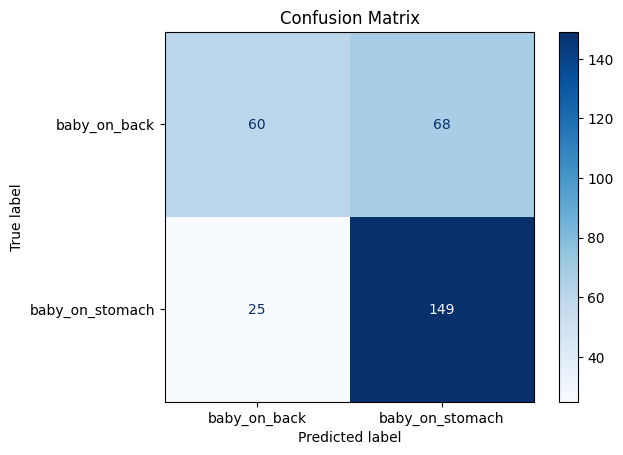

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_in_dataset)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

** Try other classifiers **

# COMBINATION 2 (dataset 2, model 2, embedding with flag)

In [71]:
dataset_folder = "onback_onstomach_v2"
embedding_type = "flag"

In [72]:
onback_onstomach_dataset = Path(dataset_folder)
X = []
y = []

for img in onback_onstomach_dataset.glob("*.jpg"):
    if img.name in file_label.keys():
        #DEBUG
        if len(y)%100 == 0:
            print(f"{int(len(y)*100/len(file_label))}%-->    {len(y)} / {len(file_label)} embeddings created")
        #DEBUG    
        result = model(img, conf=0.3, verbose=False)[0]
        prediction = result.boxes
        
        vec = embedding_builder_flag(prediction)
        X.append(vec)
        y.append(file_label[img.name])
        
print(f"FINISHED EMBEDDING CREATION, {len(y)} embeddings created")

save_embedding_label_dataset(dataset_folder, embedding_type, X, y)
print(f"New dataset (embedding - label) saved in '{dataset_folder}/{embedding_type}.csv'")

0%-->    0 / 1509 embeddings created
6%-->    100 / 1509 embeddings created
13%-->    200 / 1509 embeddings created
19%-->    300 / 1509 embeddings created
26%-->    400 / 1509 embeddings created
33%-->    500 / 1509 embeddings created
39%-->    600 / 1509 embeddings created
46%-->    700 / 1509 embeddings created
53%-->    800 / 1509 embeddings created
59%-->    900 / 1509 embeddings created
66%-->    1000 / 1509 embeddings created
72%-->    1100 / 1509 embeddings created
79%-->    1200 / 1509 embeddings created
86%-->    1300 / 1509 embeddings created
92%-->    1400 / 1509 embeddings created
99%-->    1500 / 1509 embeddings created
FINISHED EMBEDDING CREATION, 1509 embeddings created
New dataset (embedding - label) saved in 'onback_onstomach_v2/flag.csv'


In [78]:
X, y = load_embedding_label_dataset(dataset_folder, embedding_type)

**Process dataset with RANDOM FOREST**

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")

print(f"Report-------------------------------------------------")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))


Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2, 'crib': 3}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.71      0.47      0.56       128
baby_on_stomach       0.69      0.86      0.76       174

       accuracy                           0.69       302
      macro avg       0.70      0.66      0.66       302
   weighted avg       0.69      0.69      0.68       302



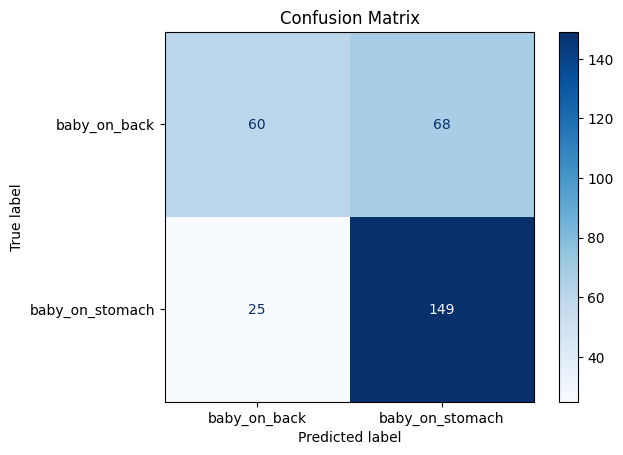

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_in_dataset)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()